In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random

import h5py
from IPython.utils import io

In [2]:
%matplotlib notebook

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [5]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

In [6]:
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities import *

In [7]:
dist = 11.4
z_sep = -10
y_offset = 4.9
test = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"z",10e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)

Your choice of lambda is not existing
Taking 1.00e-05 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.10e-05 is selected
A height of -1.00e-05 is selected


<IPython.core.display.Javascript object>


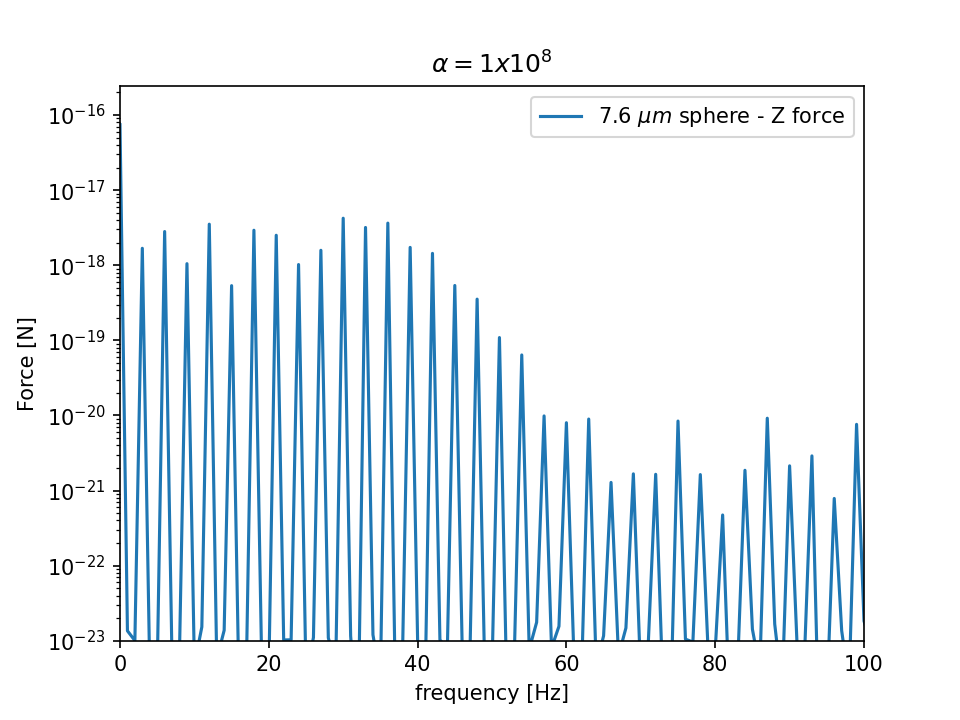

Z force [N] at 36Hz.: [3.63707654e-18]


In [8]:
def fft_norm(N, fsamp):
    "Factor to normalize FFT to ASD units"
    return np.sqrt(2 / (N * fsamp))
scale = np.sqrt(2)*fft_norm(5000, 5000)

_,ax = plt.subplots()
x = np.array(list(test[1])*1)*1.85/1.55
x10 = np.array(list(test[1])*10)*1.85/1.55
# x -= np.mean(x)
fft = np.abs(np.fft.rfft(x))*scale
angles = np.angle(np.fft.rfft(x))
# fft2 = np.abs(np.fft.rfft(x2))*scale
freq = np.fft.rfftfreq(len(x), d=1./5000)
ax.semilogy(freq, fft, label='7.6 $\mu m$ sphere - Z force')
# ax.semilogy(freqs_signal,np.array(amps)/scale2, '.')
# ax.semilogy(freq, fft2, label='7.6 $\mu m$ sphere - Z force', alpha=0.5)
ax.set(xlim=(0,100), ylim=(1e-23,None), xlabel='frequency [Hz]', ylabel='Force [N]', title=r'$\alpha=1x10^{8}$')
ax.legend()
print('Z force [N] at 36Hz.:', fft[freq==36])
force_36 = fft[freq==36]

In [9]:
scale2 = 1e17
x_phase = (x10)*scale2

In [8]:
##mock bdf with scaled Z signal model
bdf_ = load_dir(dirname='/data/new_trap/20200316/Bead1/Shaking/Shaking368/', 
                         file_prefix='Shaking0', start_file=0, max_file=1)[0]
bdf_.z2 = x_phase
print(x_phase.shape)

No laser power data
100  files in folder
1  files loaded
(50000,)


In [9]:
fit_kwargs = {'A': 0.3, 'f': 3, 'phi': np.pi,
              'error_A': 0.1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [0.0001, 1000],
              'print_level': 0, 'fix_A': False, 'fix_f': True, 'fix_phi': False}
A,e,m1 = gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, bandwidth=2, decimate=10, **fit_kwargs)

***************************************************
Z2-amplitude:  1.86e-01
reduced chi2:  0.0002494594009692099


In [10]:
freqs_signal = 3*np.arange(1,22)
freqs_signal2 = 3*np.array([12, 11, 4, 6, 7,13,9,8])

amps = []
phases = []
for freq_ in freqs_signal2:
    fit_kwargs['f'] = freq_
    A, _, m1 = gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, decimate=10, bandwidth=2, **fit_kwargs)
    amps.append(A)
    phases.append(m1.values[2])

***************************************************
Z2-amplitude:  3.64e-01
reduced chi2:  1.1829077993294233e-06
***************************************************
Z2-amplitude:  3.18e-01
reduced chi2:  1.1132860258136478e-06
***************************************************
Z2-amplitude:  3.52e-01
reduced chi2:  1.5568311751598567e-06
***************************************************
Z2-amplitude:  2.93e-01
reduced chi2:  1.0113594881841468e-06
***************************************************
Z2-amplitude:  2.51e-01
reduced chi2:  7.000411788203838e-07
***************************************************
Z2-amplitude:  1.73e-01
reduced chi2:  3.835493940087587e-07
***************************************************
Z2-amplitude:  1.58e-01
reduced chi2:  4.949354734075253e-07
***************************************************
Z2-amplitude:  1.02e-01
reduced chi2:  1.8187648127891072e-07


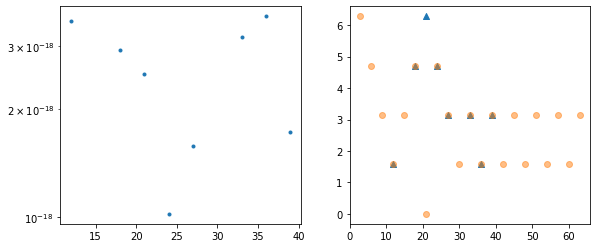

In [11]:
angles_signal = np.array([angles[freq==freq_] for freq_ in freqs_signal])
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].semilogy(freqs_signal2, np.array(amps)/scale2%(2*np.pi), '.')
ax[1].scatter(freqs_signal2, phases, marker='^')
ax[1].scatter(freqs_signal, (angles_signal+np.pi/2)%(2*np.pi), alpha=0.5)

In [15]:
def get_force(dist=11.4, lamb=100):
    
    freqs_signal = 3*np.arange(1,22)
    z_sep = -10
    y_offset = 4.9
    test = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"z",lamb*1e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                         alpha=1e8, bead_size=3.8e-6)

    scale = np.sqrt(2)*fft_norm(5000, 5000)
    x = np.array(list(test[1])*1)*1.85/1.55
    fft = np.abs(np.fft.rfft(x))*scale
    angles = np.angle(np.fft.rfft(x))
    freq = np.fft.rfftfreq(len(x), d=1./5000)

    forces_tmp = np.array([fft[freq==freq_] for freq_ in freqs_signal])
    
    return forces_tmp

def get_force_distances(lamb=100):
    forces = []
    for dist_ in np.arange(1,20, 0.1):
        forces.append(get_force(dist=dist_, lamb=lamb))
    return forces

In [40]:
fff = np.array(get_force_distances(lamb=100))
# fff2x = np.array(get_force_distances(lamb=3))

Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-06 for separation
Taking 8.5e-21 for height
Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of 8.47e-21 is selected
Your choice of separation or height is not existing
Taking 3.8e-06 for bead_size
Taking 1.0e-06 for separation
Taking 8.5e-21 for height
Your choice o

<IPython.core.display.Javascript object>


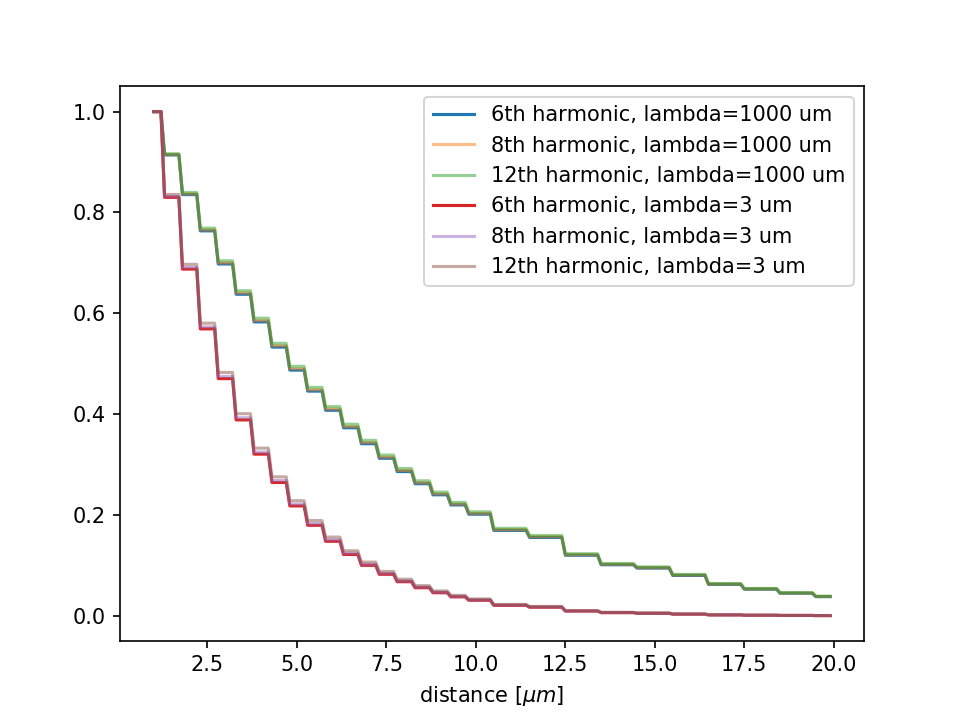

[Text(0.5, 0, 'distance [$\\mu m$]')]

In [17]:
_, ax = plt.subplots()
ax.plot(np.arange(1,20, 0.1), fff[:,6]/fff[0,6], label='6th harmonic, lambda=1000 um')
ax.plot(np.arange(1,20, 0.1), fff[:,8]/fff[0,8], alpha=0.5, label='8th harmonic, lambda=1000 um')
ax.plot(np.arange(1,20, 0.1), fff[:,12]/fff[0,12], alpha=0.5, label='12th harmonic, lambda=1000 um')

ax.plot(np.arange(1,20, 0.1), fff2[:,6]/fff2[0,6], label='6th harmonic, lambda=3 um')
ax.plot(np.arange(1,20, 0.1), fff2[:,8]/fff2[0,8], alpha=0.5, label='8th harmonic, lambda=3 um')
ax.plot(np.arange(1,20, 0.1), fff2[:,12]/fff2[0,12], alpha=0.5, label='12th harmonic, lambda=3 um')

ax.legend()

ax.set(xlabel='distance [$\mu m$]')

<IPython.core.display.Javascript object>


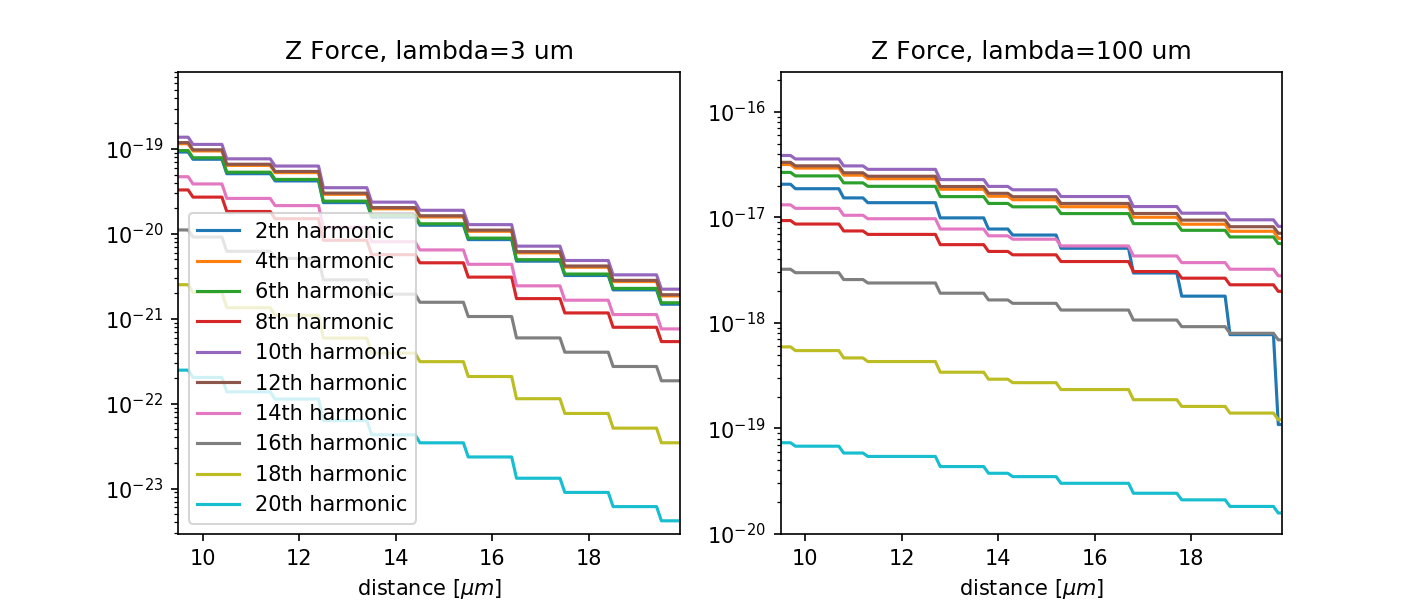

[Text(0.5, 0, 'distance [$\\mu m$]'), Text(0.5, 1.0, 'Z Force, lambda=100 um')]

In [58]:
_, ax = plt.subplots(1,2,figsize=(9.5,4), sharex=True)
[ax[0].semilogy(np.arange(1,20, 0.1), fff2[:,i], label=str(i+1)+'th harmonic') for i in range(1,21)[::2]]
[ax[1].semilogy(np.arange(1,20, 0.1), fff[:,i], label=str(i+1)+'th harmonic') for i in range(1,21)[::2]]

ax[0].legend()

ax[0].set(xlabel='distance [$\mu m$]', title='Z Force, lambda=3 um')
ax[1].set(xlabel='distance [$\mu m$]', title='Z Force, lambda=100 um')

<IPython.core.display.Javascript object>


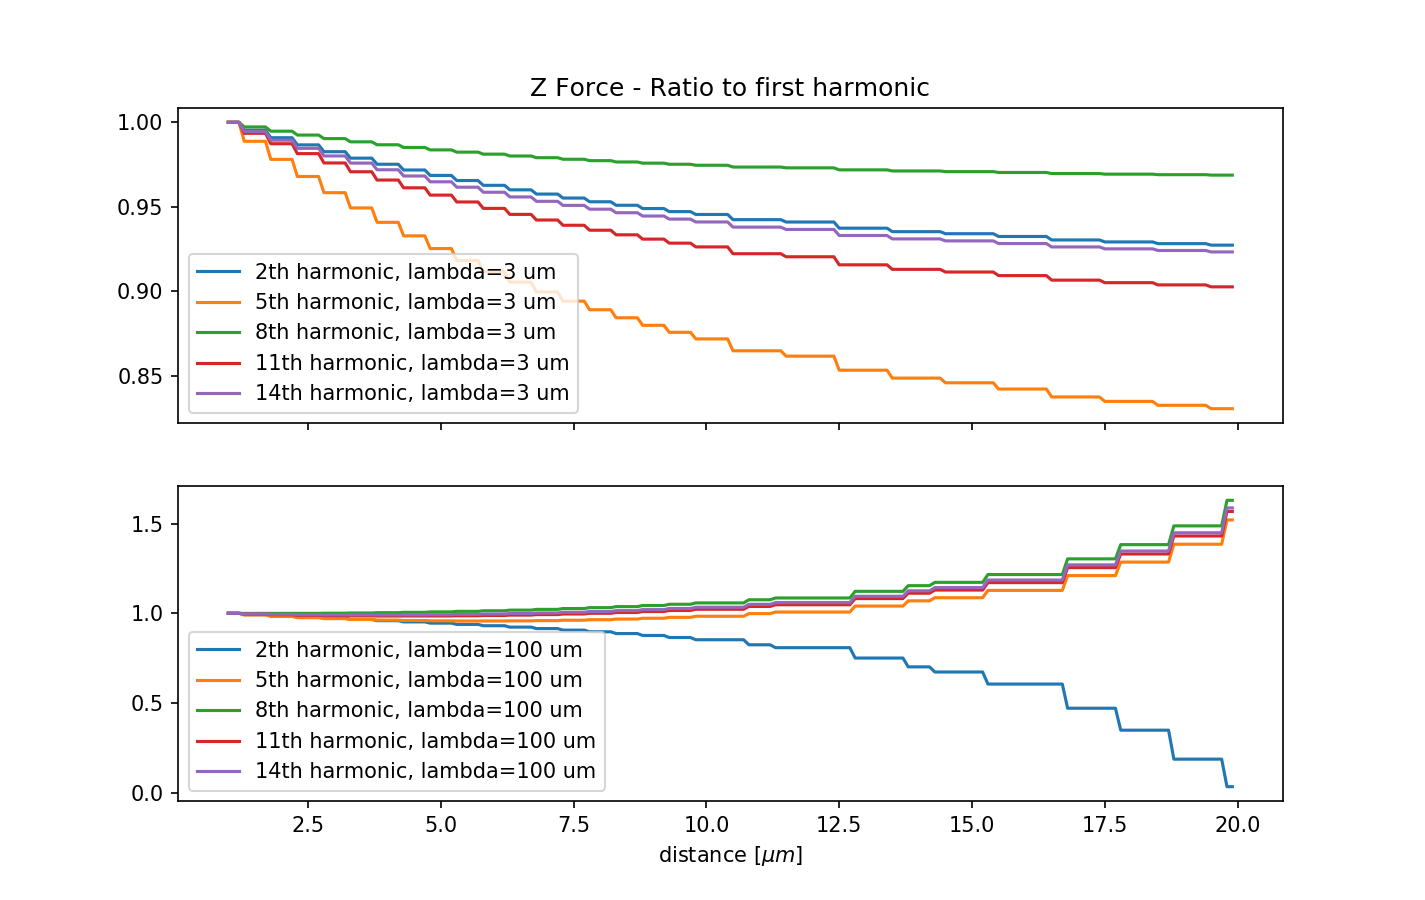

[Text(0.5, 0, 'distance [$\\mu m$]')]

In [59]:
_, ax = plt.subplots(2,1,figsize=(9.5,6), sharex=True)
[ax[0].plot(np.arange(1,20, 0.1), fff2[:,i]/fff2[:,0]/fff2[0,i]*fff2[0,0], label=str(i+1)+'th harmonic, lambda=3 um') for i in range(1,15)[::3]]
[ax[1].plot(np.arange(1,20, 0.1), fff[:,i]/fff[:,0]/fff[0,i]*fff[0,0], label=str(i+1)+'th harmonic, lambda=100 um') for i in range(1,15)[::3]]

ax[0].legend()
ax[1].legend()

ax[0].set(title='Z Force - Ratio to first harmonic')
ax[1].set(xlabel='distance [$\mu m$]')

In [82]:
index_14 = (np.arange(1,20, 0.1)<14.02)*(np.arange(1,20, 0.1)>13.95)
force_100 = fff[index_14,:].flatten()
force_6 = fff2[index_14,:].flatten()

<IPython.core.display.Javascript object>


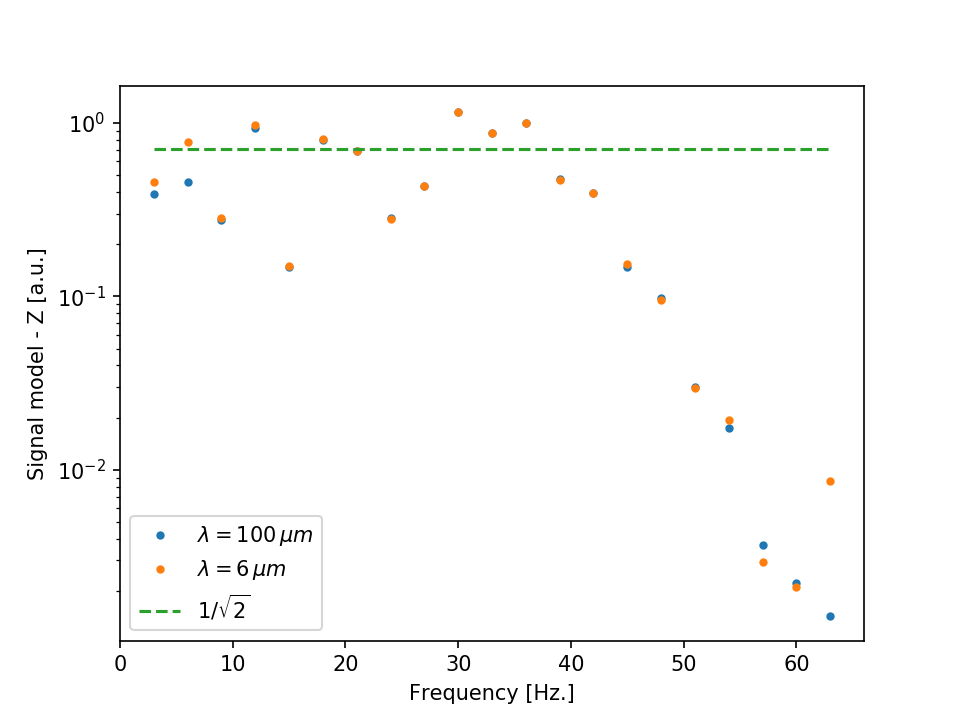

In [140]:
_,ax = plt.subplots()
ax.semilogy(np.arange(1,22)*3, force_100/force_100[11], '.', label=r'$\lambda=100\,\mu m$')
ax.semilogy(np.arange(1,22)*3, force_6/force_6[11], '.', label=r'$\lambda=6\,\mu m$')
ax.semilogy(np.arange(1,22)*3, np.arange(1,22)*0+1/np.sqrt(2), '--', label=r'1/$\sqrt{2}$')
ax.set(xlabel='Frequency [Hz.]', ylabel=r'Signal model - Z [a.u.]')
ax.legend()

In [114]:
harmonics_sen = [12, 11, 4, 6, 7,13,9,8]
signal = [force_100[harmonics_-1]/force_100[11] for harmonics_ in harmonics_sen]
sum_signal = np.array([sum(signal[:i+1]) for i in range(len(signal))])
b = 2
sum_backgrounds = np.array([b*(i+1) for i in range(len(signal))])

<IPython.core.display.Javascript object>


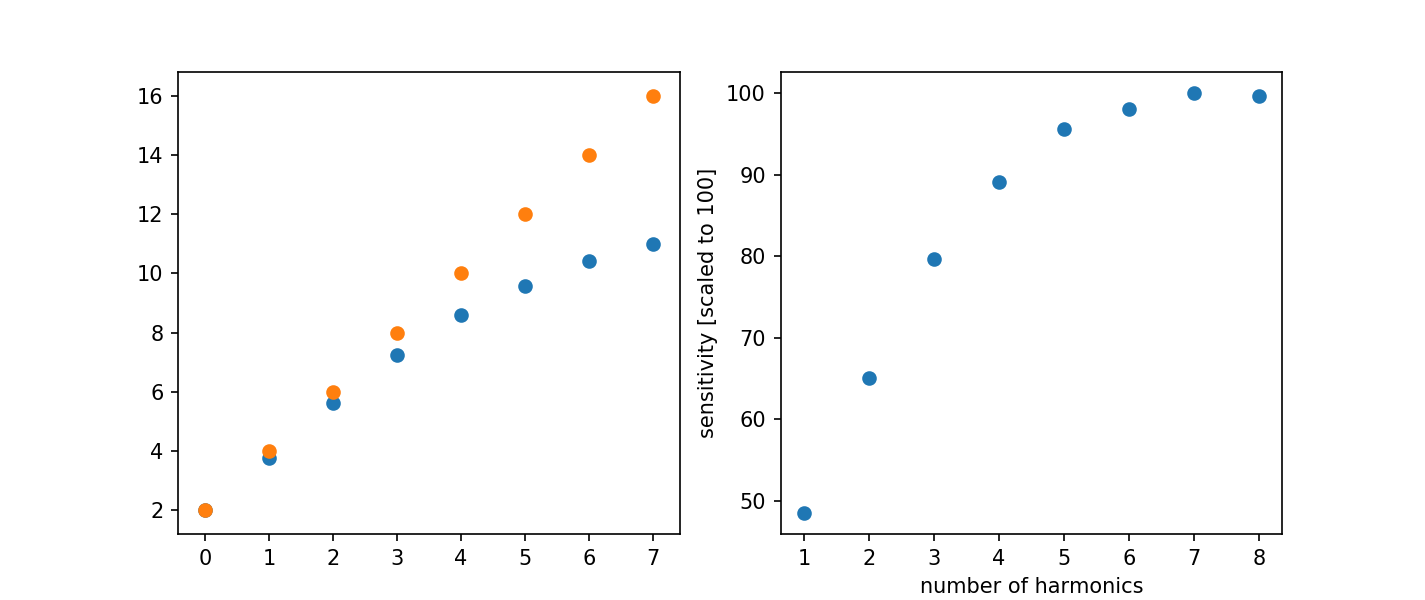

[Text(0, 0.5, 'sensitivity [scaled to 100]'),
 Text(0.5, 0, 'number of harmonics')]

In [145]:
_, ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].scatter(range(len(signal)), sum_signal*2)
ax[0].scatter(range(len(signal)), sum_backgrounds)
sens = sum_signal/np.sqrt(sum_backgrounds+sum_signal)
ax[1].scatter(np.arange(len(signal))+1, sens/np.max(sens)*100)
ax[1].set(xlabel='number of harmonics', ylabel='sensitivity [scaled to 100]')

### Including phase - Shaking378-3

In [10]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200320/Bead1/Discharge/Discharge_after_Mass_20200402/After_spinning_again_20200403/',
                         start_file=0, max_file=1000)

530  files in folder
530  files loaded


In [17]:
dis_z = [np.std(bb.response_at_freq2('z',71)) for bb in bdf_discharge]

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [11]:
bdf_z = bdf_discharge[235:265]
# bdf_x = bdf_discharge[5:10]
# bdf_y = bdf_discharge[10:]

freq = bdf_z[0].psd2('z')[0]
z_scale = bdf_z[0].psd2('z')[1][freq==71]
for bb in bdf_z:
    z_scale += bb.psd2('z')[1][freq==71]
z_scale /= len(bdf_z)

# x_scale = bdf_x[0].psd2('x')[1][freq==71]
# for bb in bdf_x:
#     x_scale += bb.psd2('x')[1][freq==71]
# x_scale /= len(bdf_x)

# y_scale = bdf_y[0].psd2('y')[1][freq==71]
# for bb in bdf_y:
#     y_scale += bb.psd2('y')[1][freq==71]
# y_scale /= len(bdf_y)

charges = 6
force = charges * 1.6e-19 * 20 / 8.6e-3 * 0.63 * np.sqrt(10) # in Newtons/sqrt(Hz)
z_scale = force/np.sqrt(z_scale)
# x_scale = force/np.sqrt(x_scale)
# y_scale = force/np.sqrt(y_scale)

In [13]:
## 1000 files of shaking data for nose floor
data_bdfs = load_dir(dirname='/data/new_trap/20200320/Bead1/Shaking/Shaking378/',
                         file_prefix='Shaking3', start_file=0, max_file=1000)
freq = data_bdfs[0].psd2('x')[0]
fftx1 = data_bdfs[0].psd2('x')[1]
ffty1 = data_bdfs[0].psd2('y')[1]
fftz1 = data_bdfs[0].psd2('z')[1]
for i in range(1,1000):
    fftx1 += data_bdfs[i].psd2('x')[1]
    fftz1 += data_bdfs[i].psd2('z')[1]
    ffty1 += data_bdfs[i].psd2('y')[1]
fftx1/=1000
ffty1/=1000
fftz1/=1000

10000  files in folder
1000  files loaded


In [12]:
## 1000 files of shaking data for nose floor
data_bdfs2 = load_dir(dirname='/data/new_trap/20200320/Bead1/Shaking/Shaking2_20200403/',
                         file_prefix='NoShaking_1', start_file=0, max_file=1000)
freq = data_bdfs2[0].psd2('x')[0]
fftx2 = data_bdfs2[0].psd2('x')[1]
ffty2 = data_bdfs2[0].psd2('y')[1]
fftz2 = data_bdfs2[0].psd2('z')[1]
for i in range(1,1000):
    fftx2 += data_bdfs2[i].psd2('x')[1]
    fftz2 += data_bdfs2[i].psd2('z')[1]
    ffty2 += data_bdfs2[i].psd2('y')[1]
fftx2/=1000
ffty2/=1000
fftz2/=1000

6905  files in folder
1000  files loaded


In [16]:
3*np.array([12, 11, 4, 6, 7,13,9,8])

array([36, 33, 12, 18, 21, 39, 27, 24])

<IPython.core.display.Javascript object>


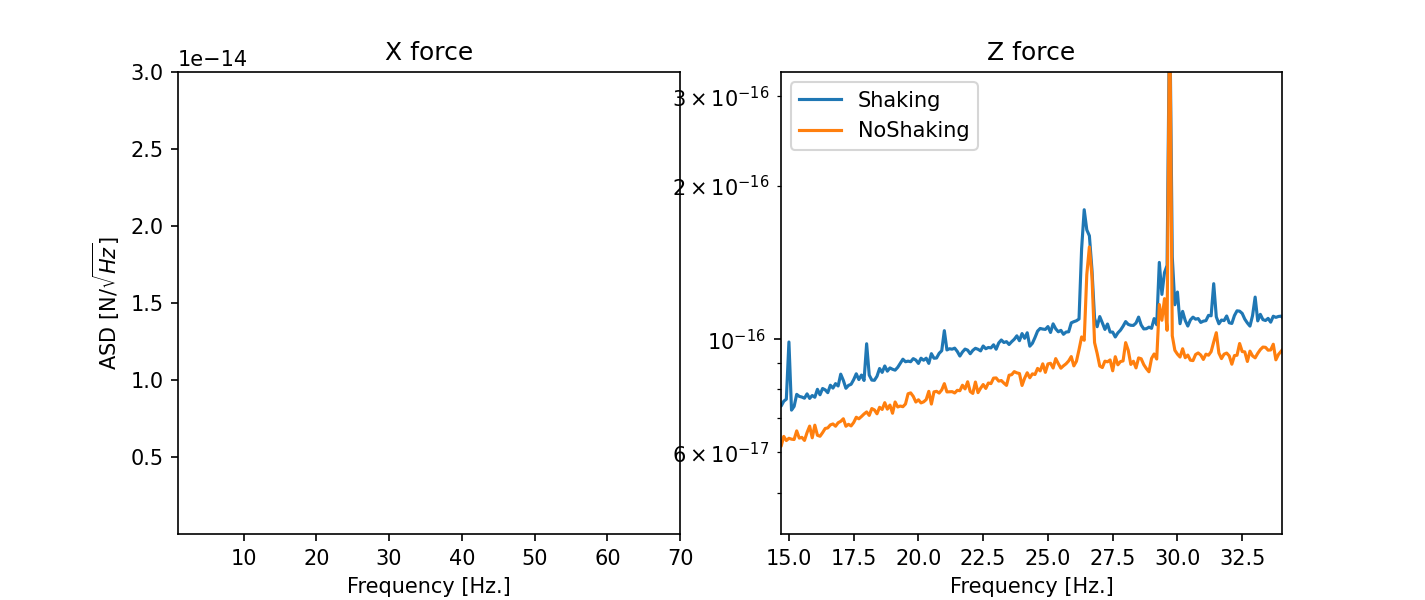

In [17]:
_,ax = plt.subplots(1,2,figsize=(9.5,4))
# ax[0].semilogy(freq, np.sqrt(fftx1)*x_scale)
ax[1].semilogy(freq, np.sqrt(fftz1)*z_scale, label='Shaking')
ax[1].semilogy(freq, np.sqrt(fftz2)*z_scale, label='NoShaking')
ax[1].legend()
ax[0].set(xlim=(1,70), ylim=(9e-18,3e-14), xlabel='Frequency [Hz.]', ylabel=r'ASD [N/$\sqrt{Hz}$]', title='X force')
_ = ax[1].set(xlim=(1,70), ylim=(9e-18,3e-14), xlabel='Frequency [Hz.]', title=r'Z force')
# print(np.sqrt(fftx1[freq==36])*x_scale/np.sqrt(10), np.sqrt(fftz1[freq==36])*z_scale/np.sqrt(10))

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


<IPython.core.display.Javascript object>


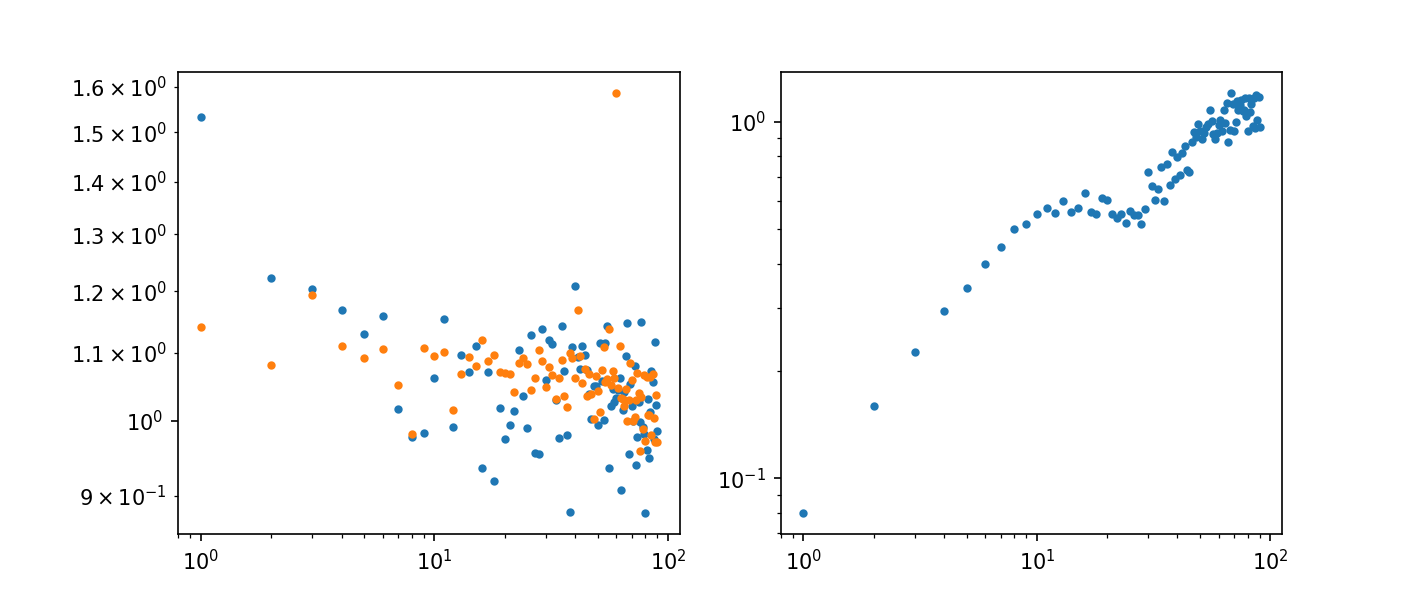

In [20]:
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_X_m300k_250s_1hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Y_m300k_250s_1hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Z_m300k_250s_1hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)
gfw.build_transfer_function([tf_x, tf_y, tf_z], base_freq=1, number_of_harmonics=90, scale_freq=71, plot=True)

In [21]:
fit_kwargs = {'A': 30, 'f': 36, 'phi': np.pi,
              'error_A': 0.1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [0.0001, 1000],
              'print_level': 0, 'fix_A': False, 'fix_f': True, 'fix_phi': False}
gfw.get_z_amplitude(bdf=tf_z, noise_rms=1, decimate=10, bandwidth=1, **fit_kwargs)[2].values

***************************************************
Z2-amplitude:  3.89e+01
reduced chi2:  267.9111284196778


<ValueView of Minuit at 2c8ce28>
  A: 38.93407200968503
  f: 36.0
  phi: 1.8428445259252597

In [29]:
# phase from tf, only at the search frequencies, using fit method
freq_search = np.array([12, 11, 4, 6, 7,13,9,8])*3
tf_phase = []
for freq_ in freq_search:
    fit_kwargs['f'] = freq_
    tf_phase.append(gfw.get_z_amplitude(bdf=tf_z, noise_rms=1, decimate=10, bandwidth=1, **fit_kwargs)[2].values[2])

***************************************************
Z2-amplitude:  3.89e+01
reduced chi2:  267.9111284196778
***************************************************
Z2-amplitude:  3.32e+01
reduced chi2:  220.52278055038633
***************************************************
Z2-amplitude:  2.50e+01
reduced chi2:  117.17943806057056
***************************************************
Z2-amplitude:  2.83e+01
reduced chi2:  127.00368685937268
***************************************************
Z2-amplitude:  2.83e+01
reduced chi2:  150.52874246346585
***************************************************
Z2-amplitude:  3.52e+01
reduced chi2:  257.5361635762363
***************************************************
Z2-amplitude:  2.80e+01
reduced chi2:  237.9207034735624
***************************************************
Z2-amplitude:  2.65e+01
reduced chi2:  178.23592531081826


In [26]:
tf_angles = np.angle(np.fft.rfft(tf_z.z2))
tf_freq = np.fft.rfftfreq(len(tf_z.z2), d=1./5000)

In [28]:
# tf phase of all frequencies - using fft method
tf_phase2 = [] 
for freq_ in range(1,80):
    tf_phase2.append(tf_angles[tf_freq==freq_])

In [30]:
# electrodes phase of all frequencies - using fft method
efield_angles = np.angle(np.fft.rfft(np.array(list(tf_z.electrode_data[0])*10)))
tf_freq2 = np.fft.rfftfreq(50000, d=1./5000)
efield_phase = []
for freq_ in range(1,80):
    efield_phase.append(efield_angles[tf_freq2==freq_])

In [34]:
phases_diff = (np.array(tf_phase2).flatten()-np.array(efield_phase).flatten())%(2*np.pi)
phases_diff2 = []
for pp in phases_diff:
    if pp<-4:
        phases_diff2.append(pp+2*np.pi)
    else:
        phases_diff2.append(pp)

<IPython.core.display.Javascript object>


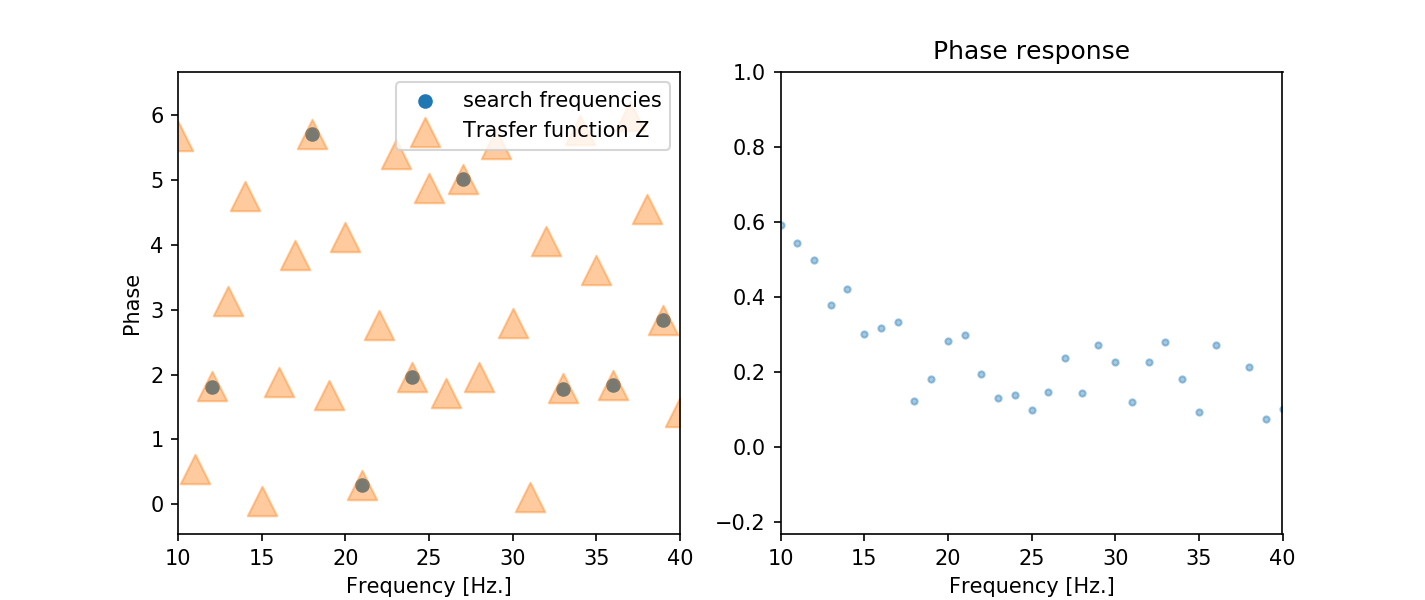

In [41]:
_,ax = plt.subplots(1,2,figsize=(9.5,4), sharex=False)
ax[0].scatter(freq_search, tf_phase, label='search frequencies')
ax[0].scatter(range(1,80), (np.array(tf_phase2)+np.pi/2)%(2*np.pi), alpha=0.4, s=200, marker='^', label='Trasfer function Z')
ax[1].plot(range(1,80), phases_diff2, '.', alpha=0.4 , label='tf e-field phases')
ax[0].set(xlim=(10,40), xlabel='Frequency [Hz.]', ylabel='Phase')
ax[1].set(xlim=(10,40), xlabel='Frequency [Hz.]', title='Phase response', ylim=(None,1))
ax[0].legend(loc='upper right')

In [38]:
# phase diff, only at the search frequencies
freq_search = np.array([12, 11, 4, 6, 7,13,9,8])*3
phases_response = []
for freq_ in freq_search:
    fit_kwargs['f'] = freq_
    phases_response.append(phases_diff2[freq_-1])

In [53]:
phases_response, np.mean(phases_diff2[16:36]), np.std(phases_diff2[20:36])

([0.2704414165064554,
  0.2789773969914008,
  0.4972655040181506,
  0.12173018528487534,
  0.2983395293059272,
  0.07487998250901295,
  0.23739180944347327,
  0.13771587208848507],
 0.1984128722775211,
 0.06629616236033481)

In [162]:
m1_zscale = gfw.build_z_response(bdf_z, drive_freq=71, charges=6, bandwidth=2, decimate=10)

***************************************************
Z2-amplitude:  2.69e+02
reduced chi2:  218.17211664824794
***************************************************
Z2-amplitude:  2.61e+02
reduced chi2:  544.9449187856881
***************************************************
Z2-amplitude:  2.74e+02
reduced chi2:  370.69379302980815
***************************************************
Z2-amplitude:  2.78e+02
reduced chi2:  528.049019188792
***************************************************
Z2-amplitude:  2.80e+02
reduced chi2:  461.3500980604403
***************************************************
Z2-amplitude:  2.75e+02
reduced chi2:  465.4616020235652
***************************************************
Z2-amplitude:  2.70e+02
reduced chi2:  279.8526446487309
***************************************************
Z2-amplitude:  2.66e+02
reduced chi2:  279.14421818905066
***************************************************
Z2-amplitude:  2.67e+02
reduced chi2:  395.08567875267073
****************

In [65]:
np.mean([m1_.values[2] for m1_ in m1_zscale])

3.153994559681628

In [77]:
gfw.BDFs = data_bdfs
gfw.build_noise_array_z(40, bandwidth=2)

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


z2 noise level:  23.773706725413124  std:  3.6887585631170463


### Phase not fixed

In [204]:
drive_freq = 21
# m1_data_notFixed = []
for bdf_ in data_bdfs:
    phi_rand = np.random.uniform()*2*np.pi
    phi_signal = 0*np.pi+0.2
    fit_kwargs = {'A': 10, 'f': drive_freq, 'phi': phi_signal,
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [0, 2 * np.pi],
                  'limit_A': [0, 100000],
                  'print_level': 0, 'fix_f': True, 'fix_phi': False}
    m1_data_notFixed.append(gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, bandwidth=2, decimate=10, **fit_kwargs)[2])
    fit_kwargs['fix_phi'] = True
    m1_data_Fixed.append(gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, bandwidth=2, decimate=10, **fit_kwargs)[2])

for bdf_ in data_bdfs2:
    phi_rand = np.random.uniform()*2*np.pi
    phi_signal = 0*np.pi+0.2
    fit_kwargs = {'A': 10, 'f': drive_freq, 'phi': phi_signal,
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [0, 2 * np.pi],
                  'limit_A': [0, 100000],
                  'print_level': 0, 'fix_f': True, 'fix_phi': False}
    m2_data_notFixed.append(gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, bandwidth=2, decimate=10, **fit_kwargs)[2])
    fit_kwargs['fix_phi'] = True
    m2_data_Fixed.append(gfw.get_z_amplitude(bdf=bdf_, noise_rms=1, bandwidth=2, decimate=10, **fit_kwargs)[2])

***************************************************
Z2-amplitude:  4.01e+00
reduced chi2:  275.46139232631907
***************************************************
Z2-amplitude:  2.78e-11
reduced chi2:  283.5010332293337
***************************************************
Z2-amplitude:  6.71e+00
reduced chi2:  260.6889787028247
***************************************************
Z2-amplitude:  6.37e+00
reduced chi2:  262.9117967956746
***************************************************
Z2-amplitude:  2.41e+00
reduced chi2:  173.79074721053587
***************************************************
Z2-amplitude:  2.11e-01
reduced chi2:  176.68212284095432
***************************************************
Z2-amplitude:  8.92e+00
reduced chi2:  217.38918487278306
***************************************************
Z2-amplitude:  7.77e-11
reduced chi2:  257.22283197284645
***************************************************
Z2-amplitude:  8.33e+00
reduced chi2:  343.5017904594229
**************

In [205]:
# phases_notFixed = [m1_.values[2] for m1_ in m1_data_notFixed]
amps_notFixed = np.array([m1_.values[0] for m1_ in m1_data_notFixed])
amps_notFixed_bck = np.array([m1_.values[0] for m1_ in m2_data_notFixed])
amps_Fixed = np.array([m1_.values[0] for m1_ in m1_data_Fixed])
amps_Fixed_bck = np.array([m1_.values[0] for m1_ in m2_data_Fixed])

In [182]:
print(np.mean(np.array(amps_notFixed)/scale1), np.std(np.array(amps_notFixed)/scale1)/np.sqrt(1000))
print(np.mean(np.array(amps_Fixed)/scale1), np.std(np.array(amps_Fixed)/scale1)/np.sqrt(1000))

5.813163049857986e-17 9.817272900915878e-19
2.122538497118178e-17 9.629914893417967e-19


<IPython.core.display.Javascript object>


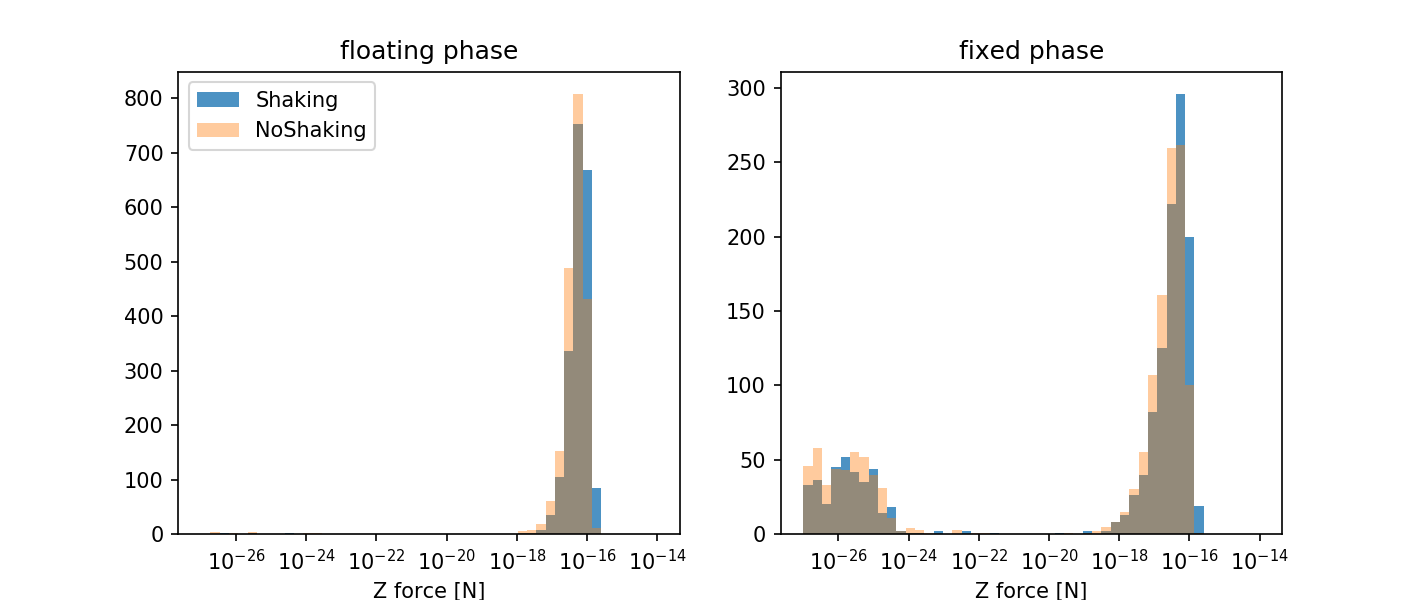

[None, Text(0.5, 0, 'Z force [N]'), Text(0.5, 1.0, 'fixed phase')]

In [220]:
## 11 & 12 harmonics
bins1 = np.logspace(-4, 2., 50) 
fig, ax = plt.subplots(1,2,figsize=(9.5,4))
# ax.scatter(range(1000), phases_notFixed)
ax[0].hist(amps_notFixed[:2000]/scale1, bins=bins1, alpha=0.8, label='Shaking')
ax[0].hist(amps_notFixed_bck[:2000]/scale1*1., bins=bins1, alpha=0.4, label='NoShaking')
ax[0].set(xscale='log', xlabel='Z force [N]', title='floating phase')
ax[0].legend()
scale1 = gfw.scale_Z2 * np.interp(drive_freq, gfw.tf_freq, gfw.tf_ffts[2])
# ax[1].hist(np.array(amps_notFixed)/scale1, bins=bins1)
ax[1].hist(amps_Fixed[:2000]/scale1, bins=bins1, alpha=0.8, label='Shaking')
ax[1].hist(amps_Fixed_bck[:2000]/scale1*1., bins=bins1, alpha=0.4, label='NoShaking')
ax[1].set(xscale='log', xlabel='Z force [N]', title='fixed phase')

In [186]:
print('mean: ', np.mean(np.array(amps_notFixed)/scale1), '\nstd :', np.std(np.array(amps_notFixed)/scale1)/np.sqrt(1000))
print('\nmean: ', np.mean(np.array(amps_Fixed)/scale1), '\nstd :', np.std(np.array(amps_Fixed)/scale1)/np.sqrt(1000))

mean:  5.813163049857986e-17 
std : 9.817272900915878e-19

mean:  2.122538497118178e-17 
std : 9.629914893417967e-19


<IPython.core.display.Javascript object>


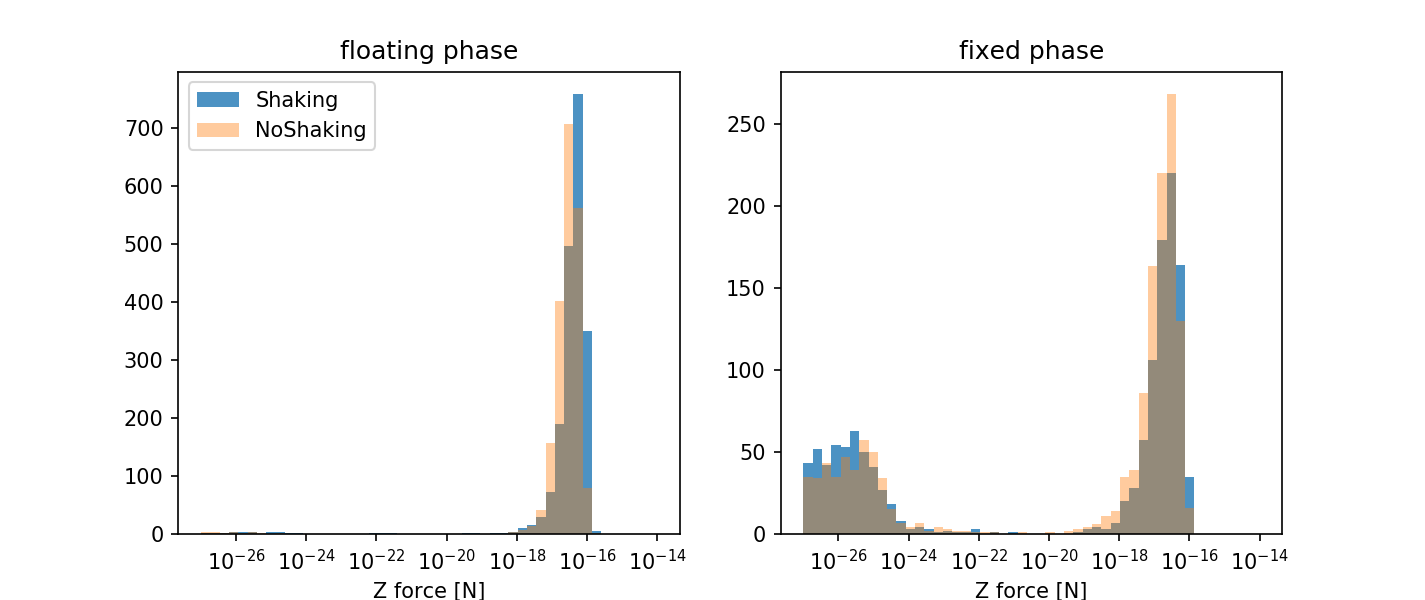

[None, Text(0.5, 0, 'Z force [N]'), Text(0.5, 1.0, 'fixed phase')]

In [219]:
## 4 & 6 harmonics
bins = np.logspace(-4, 2., 40) 
fig, ax = plt.subplots(1,2,figsize=(9.5,4))
# ax.scatter(range(1000), phases_notFixed)
ax[0].hist(amps_notFixed[2000:4000]/scale1, bins=bins1, alpha=0.8, label='Shaking')
ax[0].hist(amps_notFixed_bck[2000:4000]/scale1*1., bins=bins1, alpha=0.4, label='NoShaking')
ax[0].set(xscale='log', xlabel='Z force [N]', title='floating phase')
ax[0].legend()
scale1 = gfw.scale_Z2 * np.interp(drive_freq, gfw.tf_freq, gfw.tf_ffts[2])
# ax[1].hist(np.array(amps_notFixed)/scale1, bins=bins1)
ax[1].hist(amps_Fixed[2000:4000]/scale1, bins=bins1, alpha=0.8, label='Shaking')
ax[1].hist(amps_Fixed_bck[2000:4000]/scale1*1., bins=bins1, alpha=0.4, label='NoShaking')
ax[1].set(xscale='log', xlabel='Z force [N]', title='fixed phase')

In [200]:
print('mean: ', np.mean(np.array(amps_notFixed[2000:])/scale1), '\nstd :', np.std(np.array(amps_notFixed[2000:])/scale1)/np.sqrt(1000))
print('\nmean: ', np.mean(np.array(amps_Fixed[2000:])/scale1), '\nstd :', np.std(np.array(amps_Fixed[2000:])/scale1)/np.sqrt(1000))

mean:  4.823631011508427e-17 
std : 9.281538645044685e-19

mean:  1.1740500068393898e-17 
std : 6.440619150123589e-19


<IPython.core.display.Javascript object>


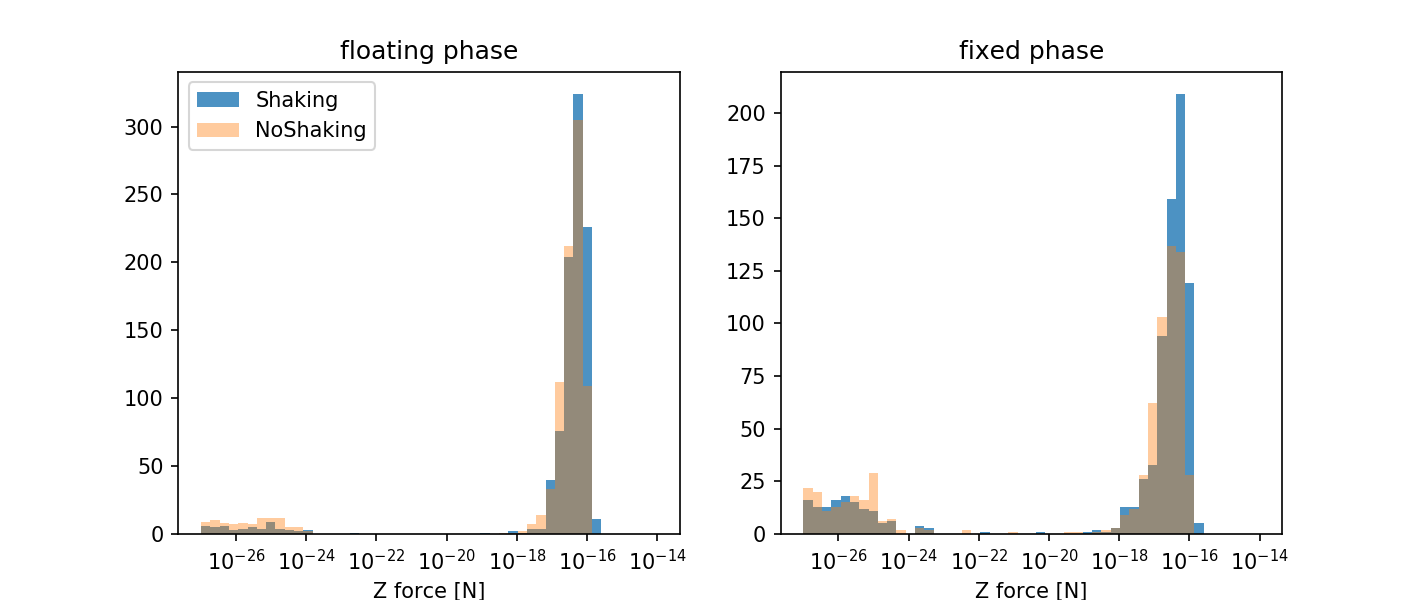

mean:  5.080791545452515e-17 
std : 1.1281099333197901e-18

mean:  3.099574089355509e-17 
std : 1.080142852751186e-18


In [218]:
## 7 harmonics
bins1 = np.logspace(-27, -14., 50) 
fig, ax = plt.subplots(1,2,figsize=(9.5,4))
# ax.scatter(range(1000), phases_notFixed)
ax[0].hist(amps_notFixed[4000:]/scale1, bins=bins1, alpha=0.8, label='Shaking')
ax[0].hist(amps_notFixed_bck[4000:]/scale1*1., bins=bins1, alpha=0.4, label='NoShaking')
ax[0].set(xscale='log', xlabel='Z force [N]', title='floating phase')
ax[0].legend()
scale1 = gfw.scale_Z2 * np.interp(drive_freq, gfw.tf_freq, gfw.tf_ffts[2])
# ax[1].hist(np.array(amps_notFixed)/scale1, bins=bins1)
ax[1].hist(amps_Fixed[4000:]/scale1, bins=bins1, alpha=0.8, label='Shaking')
ax[1].hist(amps_Fixed_bck[4000:]/scale1*1., bins=bins1, alpha=0.4, label='NoShaking')
ax[1].set(xscale='log', xlabel='Z force [N]', title='fixed phase')

print('mean: ', np.mean(np.array(amps_notFixed[4000:])/scale1), '\nstd :', np.std(np.array(amps_notFixed[4000:])/scale1)/np.sqrt(1000))
print('\nmean: ', np.mean(np.array(amps_Fixed[4000:])/scale1), '\nstd :', np.std(np.array(amps_Fixed[4000:])/scale1)/np.sqrt(1000))

In [217]:
amps_notFixed[4000:]

array([4.00890867e+00, 6.71218989e+00, 2.41331554e+00, 8.92363543e+00,
       8.33171388e+00, 5.00864085e+00, 0.00000000e+00, 1.09558207e+01,
       3.96044686e+00, 2.88917132e+00, 1.23053599e+01, 1.12961280e+00,
       3.88578059e-11, 6.36105470e+00, 5.79736938e+00, 7.77156117e-11,
       1.05409023e+01, 4.87873499e+00, 1.11022302e-11, 6.31309354e+00,
       3.98206283e+00, 4.80919599e+00, 4.00223733e+00, 6.30204816e-02,
       8.57758309e-08, 1.21114295e+00, 4.68973114e+00, 1.66533454e-11,
       1.08076642e+00, 5.55111512e-12, 5.16253706e-10, 2.70550514e+00,
       6.82787160e-10, 8.80891523e-01, 8.69658193e+00, 2.91326846e+00,
       8.77076189e-09, 5.78959095e+00, 6.47629143e+00, 1.02471837e+01,
       1.90154652e+00, 2.58304875e+00, 8.07382954e+00, 1.30665402e+00,
       7.77898718e+00, 2.60902411e-10, 3.99215584e+00, 5.43537502e+00,
       1.51961683e+00, 2.91962078e+00, 2.88123393e+00, 4.51373154e+00,
       0.00000000e+00, 2.25930386e-09, 2.88608889e+00, 3.22714672e+00,
      

In [223]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

In [233]:
df = pd.read_pickle("/data/new_trap_processed/processed_files/20200320/Bead1/Shaking/Shaking378/Shaking3_aux.pkl") #here one could put the respective file name
height_cal = df["height_cal"]

In [231]:
height_cal.shape

(100,)

<IPython.core.display.Javascript object>


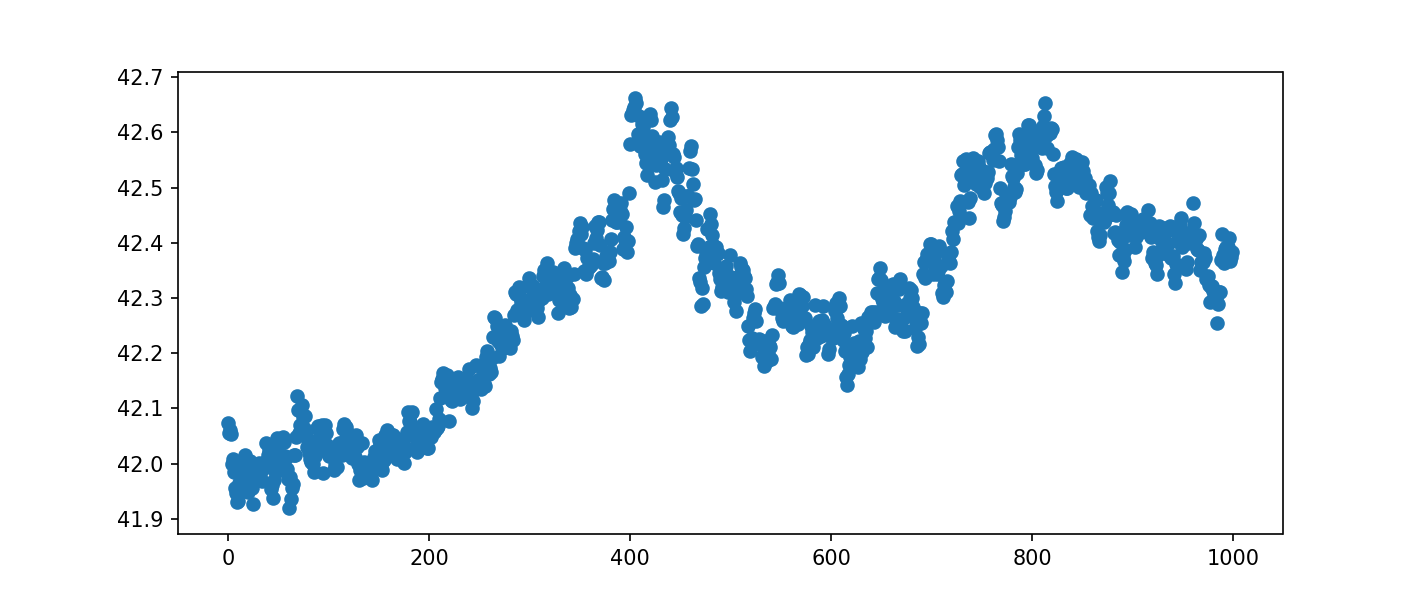

In [234]:
_,ax = plt.subplots(figsize=(9.5,4))
ax.scatter(range(1000), height_cal[::10])